<a href="https://colab.research.google.com/github/saif-byte/DataSciencePortfolio/blob/main/Credit%20Risk%20Scoring/Credit_Risk_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Credit Risk Scoring

In this project , we will predict whether the customer is going to default, if so then the bank will not issue the credit card to that person. We have used the attributes of people who had previously gone default. The dataset is from https://github.com/gastonstat/CreditScoring/ . 

In [392]:
#importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier , export_text 
from sklearn.metrics import roc_auc_score 
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

import pickle , requests

%matplotlib inline

##Reading and Preprocessing Data

In [310]:
df = pd.read_csv("/content/CreditScoring.csv")
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [311]:
df.columns = df.columns.str.lower()

In [312]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [313]:
#now we will convert these numerical values to what they represent.
status_values = {
    1:"ok",
    2:"default",
    0:"unk"
}
df.status = df.status.map(status_values)
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


In [314]:
home_values = {
 1: 'rent',
 2: 'owner',
 3: 'private',
 4: 'ignore',
 5: 'parents',
 6: 'other',
 0: 'unk'
}
df.home = df.home.map(home_values) 
marital_values = {
 1: 'single',
 2: 'married',
 3: 'widow',
 4: 'separated',
 5: 'divorced',
 0: 'unk'
}
df.marital = df.marital.map(marital_values)
records_values = {
 1: 'no',
 2: 'yes',
 0: 'unk'
}
df.records = df.records.map(records_values)
job_values = {
 1: 'fixed',
 2: 'partime',
 3: 'freelance',
 4: 'others',
 0: 'unk'
}
df.job = df.job.map(job_values) 

In [315]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [316]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [317]:
#we can see there are some 9999999 values in max row for some columns, this means these columns have nan values
#to fix this
for c in ['income', 'assets' , 'debt']:
  df[c] = df[c].replace(to_replace = 99999999, value = np.nan)

In [318]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [319]:
#now let us look into our target variable "status"
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

In [320]:
#Let us remove one unknown value as it is not important for our dataset
df = df[df["status"]!="unk"]

###Dataset Preparation

In [321]:
#first split data into train, validation and test sets
df_train_full , df_test = train_test_split(df , test_size = 0.2 , random_state=2)
df_train , df_val = train_test_split(df_train_full , test_size = 0.25 , random_state=2)

In [322]:
print((len(df_train),len(df_val) , len(df_test)))

(2672, 891, 891)


In [323]:
y_train = (df_train.status=='default').values
y_val = (df_val.status=='default').values
del(df_train['status'])
del(df_val['status'])

In [324]:
#now to prepare our X first we need to fill  null values in our columns
df_train = df_train.fillna(0)
df_val = df_val.fillna(0) 

In [325]:
#now we will do one hot encoding to our categorical variables
train_dict  = df_train.to_dict("records")
val_dict = df_val.to_dict("records")
train_dict[0]

{'age': 27,
 'amount': 400,
 'assets': 0.0,
 'debt': 0.0,
 'expenses': 58,
 'home': 'rent',
 'income': 133.0,
 'job': 'fixed',
 'marital': 'married',
 'price': 1136,
 'records': 'no',
 'seniority': 0,
 'time': 60}

In [326]:
#now we can use this list of dictionaries to use in DictVectorizer
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

##Decision Tree Classifier

In [327]:
dt = DecisionTreeClassifier()
dt.fit(X_train , y_train)

DecisionTreeClassifier()

##Evaluation

###AUC Score

In [328]:
#we will now calculate auc score to evalute our model
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

1.0

In [329]:
#we can see that this gives us score of 100%. now check on validations set

In [330]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val ,y_pred)

0.6601121540899672

In [331]:
#we can see that our auc score fell to 65% while predicting validation set, it is a case of overfitting

In [332]:
#now let us tune the max_depth of our decision tree to reduce its complexity
dt = DecisionTreeClassifier(max_depth = 2)
dt.fit(X_train , y_train)

DecisionTreeClassifier(max_depth=2)

In [333]:
#we can also visualize this tree
tree_text = export_text(dt , feature_names=dv.feature_names_)
print(tree_text)

|--- seniority <= 2.50
|   |--- job=fixed <= 0.50
|   |   |--- class: True
|   |--- job=fixed >  0.50
|   |   |--- class: False
|--- seniority >  2.50
|   |--- records=no <= 0.50
|   |   |--- class: False
|   |--- records=no >  0.50
|   |   |--- class: False



In [334]:
#now let us see auc score
y_pred = dt.predict_proba(X_train)[:,1]
auc_train= roc_auc_score(y_train , y_pred)
y_pred = dt.predict_proba(X_val)[:,1]
auc_val = roc_auc_score(y_val , y_pred)
print(f'train auc score: {auc_train}\nvalidation auc score: {auc_val}')



train auc score: 0.7196853699496197
validation auc score: 0.726276971839571


In [335]:
#We can see that train auc score dropped but validation auc score increased, this mean the model is 
#not overfitting the data

In [336]:
#Now let us see for other depths
for d in [1,2,3,4,5,6,7,8,9,10,15,20,None]:
  dt = DecisionTreeClassifier(max_depth = d)
  dt.fit(X_train , y_train)
  y_pred = dt.predict_proba(X_val)[:,1]
  auc = roc_auc_score(y_val , y_pred)
  print(f'{d} ---> {auc}')

1 ---> 0.6442642935511398
2 ---> 0.726276971839571
3 ---> 0.7538004388638303
4 ---> 0.7618188467633792
5 ---> 0.7644794587346092
6 ---> 0.7485858832134584
7 ---> 0.735730830184079
8 ---> 0.7049341704254541
9 ---> 0.6809856150188955
10 ---> 0.6715744239912227
15 ---> 0.6422497866634158
20 ---> 0.6511733512129708
None ---> 0.6413354870169451


In [337]:
#we can see that best three values of depth are 5 , 4 , 3
#now we will check best value for parameter min_sample_leaf

for d in [3,4,5]:
  print('depth: %s'%d)
  for s in [1, 5, 10, 15, 20, 50, 100, 200]:
    dt = DecisionTreeClassifier(max_depth = d , min_samples_leaf = s)
    dt.fit(X_train,y_train)
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val , y_pred)
    print('%s --> %.3f' %(s,auc))
  print()

depth: 3
1 --> 0.754
5 --> 0.754
10 --> 0.754
15 --> 0.754
20 --> 0.754
50 --> 0.754
100 --> 0.732
200 --> 0.744

depth: 4
1 --> 0.762
5 --> 0.762
10 --> 0.757
15 --> 0.757
20 --> 0.758
50 --> 0.772
100 --> 0.738
200 --> 0.744

depth: 5
1 --> 0.764
5 --> 0.769
10 --> 0.769
15 --> 0.770
20 --> 0.767
50 --> 0.780
100 --> 0.748
200 --> 0.753



In [338]:
#we can see that max auc score (78%) can be acieved by depth = 5 and and sample leaf = 50 

In [339]:
dt = DecisionTreeClassifier(max_depth=5 , min_samples_leaf = 50)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=50)

##Random Forest Classifer

In [340]:
rf = RandomForestClassifier(n_estimators = 10)
rf.fit(X_train , y_train)

RandomForestClassifier(n_estimators=10)

###Evaluation

In [341]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7886322077288797

In [342]:
#we can see that our auc score is 77.8% let us look for different values of n_estimator

In [343]:
aucs= []
for n in range(10,201,10):
  rf = RandomForestClassifier(n_estimators = n , random_state = 3)
  rf.fit(X_train , y_train)
  y_pred = rf.predict_proba(X_val)[:,1]
  auc = roc_auc_score(y_val, y_pred)
  aucs.append(auc)


Text(0, 0.5, 'AUCs')

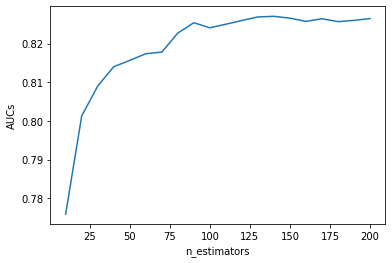

In [344]:
plt.plot(range(10,201,10) , aucs)
plt.xlabel("n_estimators")
plt.ylabel("AUCs")


In [345]:
#we can see that after around 130 estimators the value doesnt grow much

In [346]:
#now let us see tune the values for other parameter in RandomForestClassifier
all_aucs={}

for d in [5,10,20]:
  print('depth %s'%d)
  aucs = []
  for i in range(10, 201 , 10):
    rf = RandomForestClassifier(n_estimators = i , max_depth = d , random_state = 1)
    rf.fit(X_train,y_train)
    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s --> %.3f'%(i,auc))
    aucs.append(auc)
  
  all_aucs[d] = aucs
  print()

depth 5
10 --> 0.826
20 --> 0.835
30 --> 0.834
40 --> 0.835
50 --> 0.836
60 --> 0.835
70 --> 0.835
80 --> 0.836
90 --> 0.835
100 --> 0.835
110 --> 0.835
120 --> 0.835
130 --> 0.834
140 --> 0.835
150 --> 0.834
160 --> 0.835
170 --> 0.835
180 --> 0.835
190 --> 0.835
200 --> 0.835

depth 10
10 --> 0.832
20 --> 0.836
30 --> 0.836
40 --> 0.837
50 --> 0.838
60 --> 0.838
70 --> 0.838
80 --> 0.839
90 --> 0.839
100 --> 0.837
110 --> 0.837
120 --> 0.837
130 --> 0.836
140 --> 0.836
150 --> 0.836
160 --> 0.836
170 --> 0.836
180 --> 0.835
190 --> 0.835
200 --> 0.835

depth 20
10 --> 0.794
20 --> 0.817
30 --> 0.814
40 --> 0.821
50 --> 0.821
60 --> 0.821
70 --> 0.823
80 --> 0.823
90 --> 0.824
100 --> 0.824
110 --> 0.825
120 --> 0.824
130 --> 0.825
140 --> 0.824
150 --> 0.826
160 --> 0.824
170 --> 0.825
180 --> 0.826
190 --> 0.826
200 --> 0.825



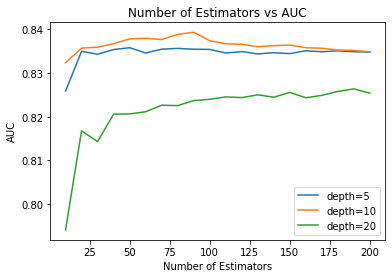

In [347]:
num_trees = list(range(10,201,10))
plt.plot(num_trees , all_aucs[5] , label = 'depth=5')
plt.plot(num_trees , all_aucs[10] , label = 'depth=10')
plt.plot(num_trees , all_aucs[20] , label = 'depth=20')
plt.title("Number of Estimators vs AUC")
plt.xlabel("Number of Estimators")
plt.ylabel("AUC")
plt.legend()

In [348]:
#with depth = 10 our auc score goes to 84% , on other depth we cannot achieve this score

In [349]:
#now we will tune min_samples_leaf
all_aucs={}

for s in [3,5,10]:
  print('sample %s'%s)
  aucs = []
  for i in range(10, 201 , 10):
    rf = RandomForestClassifier(n_estimators = i , max_depth = 10 ,min_samples_leaf=s, random_state = 1)
    rf.fit(X_train,y_train)
    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s --> %.3f'%(i,auc))
    aucs.append(auc)
  all_aucs[s] = aucs
  print()

sample 3
10 --> 0.815
20 --> 0.833
30 --> 0.830
40 --> 0.829
50 --> 0.831
60 --> 0.831
70 --> 0.834
80 --> 0.834
90 --> 0.834
100 --> 0.835
110 --> 0.836
120 --> 0.836
130 --> 0.835
140 --> 0.835
150 --> 0.835
160 --> 0.836
170 --> 0.836
180 --> 0.836
190 --> 0.836
200 --> 0.836

sample 5
10 --> 0.817
20 --> 0.832
30 --> 0.834
40 --> 0.835
50 --> 0.835
60 --> 0.835
70 --> 0.836
80 --> 0.839
90 --> 0.838
100 --> 0.838
110 --> 0.838
120 --> 0.837
130 --> 0.836
140 --> 0.836
150 --> 0.836
160 --> 0.836
170 --> 0.836
180 --> 0.837
190 --> 0.837
200 --> 0.837

sample 10
10 --> 0.819
20 --> 0.826
30 --> 0.827
40 --> 0.833
50 --> 0.834
60 --> 0.834
70 --> 0.836
80 --> 0.836
90 --> 0.836
100 --> 0.837
110 --> 0.836
120 --> 0.835
130 --> 0.836
140 --> 0.836
150 --> 0.836
160 --> 0.837
170 --> 0.837
180 --> 0.837
190 --> 0.837
200 --> 0.837



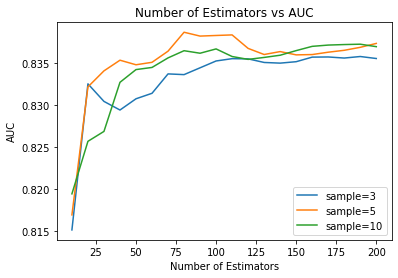

In [350]:
num_trees = list(range(10,201,10))
plt.plot(num_trees , all_aucs[3] , label = 'sample=3')
plt.plot(num_trees , all_aucs[5] , label = 'sample=5')
plt.plot(num_trees , all_aucs[10] , label = 'sample=10')
plt.title("Number of Estimators vs AUC")
plt.xlabel("Number of Estimators")
plt.ylabel("AUC")
plt.legend()

In [351]:
#we can see that best auc can be achieved bu min_samples_leaf = 5 
#so our best parameters are max_depth = 10 , min_samples_leaf = 5

In [352]:
rf = RandomForestClassifier(n_estimators = 200 , max_depth = 10 , min_samples_leaf = 5 , random_state = 1)
rf.fit(X_train , y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       random_state=1)

##Gradient Boosting

In [353]:
#first we will need to convert our train and val set to dmatrix , a special datatype use to give as input to xgboost
dtrain = xgb.DMatrix(X_train , label= y_train , feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val , label = y_val , feature_names=dv.feature_names_)

In [354]:
#now we will look for parameter of xgboost
xgbparams = {
    'eta':0.3,
    'max_depth':6,
    'min_child_weight' : 1,
    'objective':'binary:logistic',
    'nthread':8,
    'seed':1,
    'silent':1
}

In [355]:
#now we will train our xgb model
model = xgb.train(xgbparams , dtrain , num_boost_round = 10 )

In [356]:
y_pred = model.predict(dval)
y_pred[:10]

array([0.23491752, 0.18245752, 0.1169696 , 0.9392717 , 0.48931825,
       0.18239342, 0.10014149, 0.08230317, 0.08700099, 0.18377766],
      dtype=float32)

In [357]:
#now we calculate auc score
roc_auc_score(y_val , y_pred)

0.8260941119102767

In [358]:
#it is a good result but slightly worse than our random forest model.

###Evaluation

In [359]:
#to get idea how auc changes for different number of trees we can create a watchlist
watchlist = [(dtrain, 'train') , (dval , 'val')]
xgbparams = {
     'eta':0.3,
    'max_depth':6,
    'min_child_weight' : 1,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    'seed':1,
    'silent':1

}

In [360]:
#now train the model
model = xgb.train(xgbparams, dtrain , num_boost_round = 100, evals = watchlist , verbose_eval = 10)

[0]	train-auc:0.85751	val-auc:0.761002
[10]	train-auc:0.957698	val-auc:0.823272
[20]	train-auc:0.976873	val-auc:0.82393
[30]	train-auc:0.986627	val-auc:0.824064
[40]	train-auc:0.992112	val-auc:0.819408
[50]	train-auc:0.997114	val-auc:0.819127
[60]	train-auc:0.998443	val-auc:0.821011
[70]	train-auc:0.999384	val-auc:0.820194
[80]	train-auc:0.999729	val-auc:0.817506
[90]	train-auc:0.999888	val-auc:0.81806
[99]	train-auc:0.999933	val-auc:0.81839


In [361]:
train_auc = [0.85751 , 0.957698,0.976873,0.986627,0.992112,0.997114,0.998443,0.999384,0.999729,0.999888,0.999933]
val_auc = [0.761002,0.823272,0.82393,0.824064,0.819408,0.819127,0.821011,0.820194,0.817506,0.81806,0.81839]
n_of_trees = np.arange(0,101, 10)

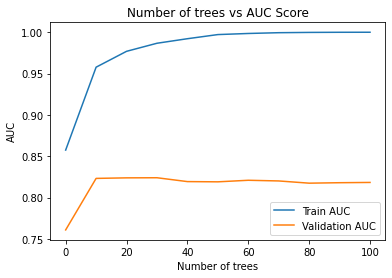

In [362]:
plt.plot(n_of_trees , train_auc , label = "Train AUC")
plt.plot(n_of_trees , val_auc , label = "Validation AUC")
plt.xlabel("Number of trees")
plt.ylabel("AUC")
plt.title("Number of trees vs AUC Score")
plt.legend()



In [363]:
#we can see that as number of trees increases the auc for training set also increases because each new tree learn 
#from the mistakes of previous tree but in validation set for first 15 trees the auc increases but after that 
#it does'nt change much. It is the case of overfitting. 

####Parameter Tuning

In [364]:
#we need to change 'eta' parameter as our dataset is small , the eta value should be 0.1

[0]	train-auc:0.85751	val-auc:0.761002
[200]	train-auc:1	val-auc:0.818457
[400]	train-auc:1	val-auc:0.817396
[499]	train-auc:1	val-auc:0.816549
[0]	train-auc:0.85751	val-auc:0.761002
[200]	train-auc:0.986977	val-auc:0.822723
[400]	train-auc:0.998616	val-auc:0.81533
[499]	train-auc:0.999658	val-auc:0.811874


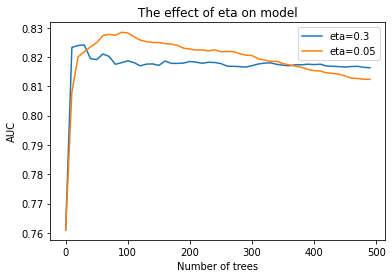

In [365]:
save = {}
model = xgb.train(xgbparams , dtrain , num_boost_round = 500 ,verbose_eval = 200, evals = watchlist , evals_result=save)
n_of_trees = np.arange(0,500,10)
fig, ax = plt.subplots()
plt.plot(n_of_trees , save['val']['auc'][::10] , label = "eta=0.3" )


xgbparams = {
     'eta':0.05,
    'max_depth':6,
    'min_child_weight' : 1,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    'seed':1,
    'silent':1

}
model = xgb.train(xgbparams , dtrain , num_boost_round = 500  ,verbose_eval = 200, evals = watchlist , evals_result=save)
plt.plot(n_of_trees , save['val']['auc'][::10] , label = "eta=0.05" )
plt.xlabel("Number of trees")
plt.ylabel("AUC")
plt.title('The effect of eta on model')
plt.legend()
plt.show()


In [366]:
#now we can tune max_depth , the default value is 6 so we can try 3 and 10 as other values


[0]	train-auc:0.85751	val-auc:0.761002
[499]	train-auc:0.999658	val-auc:0.811874
[0]	train-auc:0.767788	val-auc:0.7538
[499]	train-auc:0.943984	val-auc:0.831098
[0]	train-auc:0.920762	val-auc:0.765848
[499]	train-auc:1	val-auc:0.814086


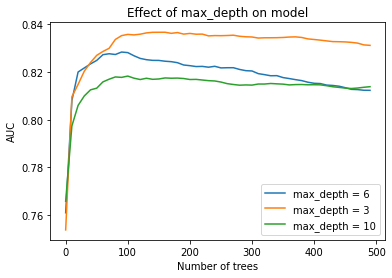

In [367]:
xgbparams['max_depth'] = 6
model = xgb.train(xgbparams ,dtrain , num_boost_round = 500,verbose_eval = 500, evals = watchlist , evals_result=save )
plt.plot(n_of_trees , save['val']['auc'][::10] , label = "max_depth = 6")
xgbparams['max_depth'] = 3
model = xgb.train(xgbparams ,dtrain , num_boost_round = 500,verbose_eval = 500, evals = watchlist , evals_result=save )
plt.plot(n_of_trees , save['val']['auc'][::10] , label = "max_depth = 3")
xgbparams['max_depth'] = 10
model = xgb.train(xgbparams ,dtrain , num_boost_round = 500,verbose_eval = 500, evals = watchlist , evals_result=save )
plt.plot(n_of_trees , save['val']['auc'][::10] , label = "max_depth = 10")
plt.xlabel("Number of trees")
plt.ylabel("AUC")
plt.title("Effect of max_depth on model")
plt.legend()



[0]	train-auc:0.767788	val-auc:0.7538
[499]	train-auc:0.929304	val-auc:0.837748
[0]	train-auc:0.767501	val-auc:0.729623
[499]	train-auc:0.90689	val-auc:0.838815
[0]	train-auc:0.767788	val-auc:0.7538
[499]	train-auc:0.943984	val-auc:0.831098


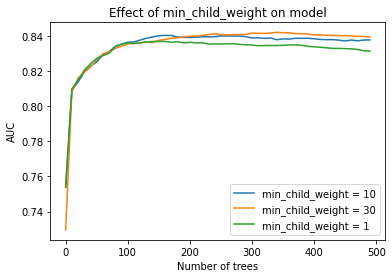

In [368]:
#we can see that best value for depth is 3
#now we will tune min_child_weight

xgbparams["max_depth"] = 3
xgbparams["min_child_weight"] = 10
model = xgb.train(xgbparams ,dtrain , num_boost_round = 500,verbose_eval = 500, evals = watchlist , evals_result=save )
plt.plot(n_of_trees , save['val']['auc'][::10] , label = "min_child_weight = 10")

xgbparams["min_child_weight"] = 30
model = xgb.train(xgbparams ,dtrain , num_boost_round = 500,verbose_eval = 500, evals = watchlist , evals_result=save )
plt.plot(n_of_trees , save['val']['auc'][::10] , label = "min_child_weight = 30")

xgbparams["min_child_weight"] = 1
model = xgb.train(xgbparams ,dtrain , num_boost_round = 500,verbose_eval = 500, evals = watchlist , evals_result=save )
plt.plot(n_of_trees , save['val']['auc'][::10] , label = "min_child_weight = 1")

plt.xlabel("Number of trees")
plt.ylabel("AUC")
plt.title("Effect of min_child_weight on model")
plt.legend()


In [369]:
#we can see that there is not much difference so we will go with default value that is 1

In [370]:
#so our final parameters are
xgbparams = {
 'eta': 0.05,
 'max_depth': 3,
 'min_child_weight': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'nthread': 8,
 'seed': 1,
 'silent': 1
}

In [371]:
#but we still have to select number of trees.
model = xgb.train(xgbparams ,dtrain , num_boost_round = 500,verbose_eval = 10, evals = watchlist , evals_result=save )


[0]	train-auc:0.767788	val-auc:0.7538
[10]	train-auc:0.817585	val-auc:0.809664
[20]	train-auc:0.841019	val-auc:0.814857
[30]	train-auc:0.853779	val-auc:0.820413
[40]	train-auc:0.863524	val-auc:0.824055
[50]	train-auc:0.87068	val-auc:0.827057
[60]	train-auc:0.877141	val-auc:0.828685
[70]	train-auc:0.882143	val-auc:0.830023
[80]	train-auc:0.886402	val-auc:0.833725
[90]	train-auc:0.890253	val-auc:0.835329
[100]	train-auc:0.893629	val-auc:0.835847
[110]	train-auc:0.896186	val-auc:0.83563
[120]	train-auc:0.898532	val-auc:0.835935
[130]	train-auc:0.901114	val-auc:0.836471
[140]	train-auc:0.903481	val-auc:0.836724
[150]	train-auc:0.905624	val-auc:0.836737
[160]	train-auc:0.907933	val-auc:0.836749
[170]	train-auc:0.909923	val-auc:0.836292
[180]	train-auc:0.911413	val-auc:0.836615
[190]	train-auc:0.912764	val-auc:0.835969
[200]	train-auc:0.914411	val-auc:0.836255
[210]	train-auc:0.915793	val-auc:0.835926
[220]	train-auc:0.917135	val-auc:0.835969
[230]	train-auc:0.918788	val-auc:0.835219
[240]	t

No handles with labels found to put in legend.


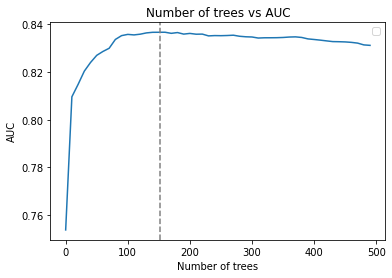

In [372]:
plt.plot(n_of_trees , save['val']['auc'][::10])
plt.axvline(x=save['val']['auc'].index(max(save['val']['auc'])) , linestyle='dashed' , color = 'gray')
plt.title("Number of trees vs AUC")
plt.xlabel("Number of trees")
plt.ylabel("AUC")
plt.legend()

In [373]:
#the max auc score is for number of trees = 150

In [374]:
#now we will train our model finally
model = xgb.train(xgbparams , dtrain , num_boost_round = 150 , evals = watchlist , evals_result=save)

[0]	train-auc:0.767788	val-auc:0.7538
[1]	train-auc:0.779406	val-auc:0.756043
[2]	train-auc:0.78383	val-auc:0.781501
[3]	train-auc:0.787119	val-auc:0.775027
[4]	train-auc:0.79518	val-auc:0.782104
[5]	train-auc:0.806207	val-auc:0.792451
[6]	train-auc:0.807854	val-auc:0.798891
[7]	train-auc:0.814331	val-auc:0.801518
[8]	train-auc:0.816436	val-auc:0.807363
[9]	train-auc:0.817293	val-auc:0.807924
[10]	train-auc:0.817585	val-auc:0.809664
[11]	train-auc:0.82636	val-auc:0.810005
[12]	train-auc:0.827677	val-auc:0.810319
[13]	train-auc:0.830365	val-auc:0.811532
[14]	train-auc:0.834173	val-auc:0.811124
[15]	train-auc:0.835558	val-auc:0.812547
[16]	train-auc:0.83741	val-auc:0.812331
[17]	train-auc:0.839547	val-auc:0.81159
[18]	train-auc:0.839427	val-auc:0.813212
[19]	train-auc:0.840403	val-auc:0.813748
[20]	train-auc:0.841019	val-auc:0.814857
[21]	train-auc:0.842769	val-auc:0.816412
[22]	train-auc:0.84369	val-auc:0.816503
[23]	train-auc:0.846737	val-auc:0.81746
[24]	train-auc:0.847496	val-auc:0.8

In [375]:
#Now we will compare all of our model aucs


In [376]:
y_test = (df_test.status=='default').values
del(df_test['status'])


In [377]:
df_test = df_test.fillna(0)
test_dict = df_test.to_dict("records")


In [378]:
X_test = dv.transform(test_dict)
X_test[0]

array([3.900e+01, 1.000e+03, 3.000e+03, 0.000e+00, 4.500e+01, 0.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       9.500e+01, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.058e+03, 1.000e+00, 0.000e+00, 1.000e+01, 6.000e+01])

In [379]:
y_pred = dt.predict_proba(X_test)[:,1]
auc_dt = roc_auc_score(y_test , y_pred)
auc_dt


0.7862066697362362

In [380]:
y_pred = rf.predict_proba(X_test)[:,1]
auc_rf = roc_auc_score(y_test , y_pred)
auc_rf

0.8250805762020653

In [381]:
dtest = xgb.DMatrix(X_test,label= y_train , feature_names=dv.feature_names_)
y_pred = model.predict(dtest)
auc_model = roc_auc_score(y_test , y_pred)
auc_model

0.83247714266921

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


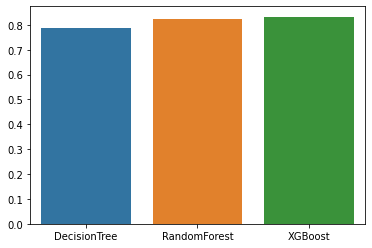

In [382]:
#we can also visualize this
sns.barplot( ["DecisionTree" , "RandomForest" , "XGBoost"], [auc_dt,auc_rf,auc_model] )

In [383]:
#we can see that the best model is xgboost 

In [386]:
#now let us save our model
with open('credit_model.bin','wb') as f_out:
  pickle.dump((dv,model), f_out)

In [393]:
person  = {'age': 41,
 'amount': 1100,
 'assets': 4000.0,
 'debt': 30.0,
 'expenses': 75,
 'home': 'private',
 'income': 80.0,
 'job': 'partime',
 'marital': 'married',
 'price': 1409,
 'records': 'no',
 'seniority': 1,
 'status': 'default',
 'time': 48}

url = 'http://localhost:9696/predict' #A
response = requests.post(url, json=person) #B
result = response.json()

result

{'default': True, 'default probablity': 0.5387210249900818}

We can see that our model correctly predicted that the person is going default. 
WE have trained using decision tree , random tree and xgboost to predict the status of the person. We then did parameter tuning to find the best parameter for our model. We compared model trained with different parameters with the help of visuals. We found that the best model is xgboost. So we saved the model and serve it on web using Flask to get real world predictions.